In [65]:
#FUNCTION TO CLEAN A SINGLE DF
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import os

col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]

for i in range(1, 33):
    col_names.append(f"Sp{i}")

file = 'STEATODA-A-12AM.txt'

df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
df = df.set_index('Index')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
df = df[df["MonStatus"] == 1]


month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
df['DateM'] = df['DateM'].str[:3].map(month_map)
df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

df.insert(0, 'Day', df['Time'].dt.day.map(day_map))

#df.to_csv('steatodaA.csv')

#FUNCTION TO FILTER THRESHOLD ON A SINGLE FILE
import pandas as pd

def filter_and_merge(df, threshold=0):
    additional_columns = df.columns[:3]
    filtered_dfs = []

    for day in range(1, 9):  
        day_df = df[df['Day'] == day] 
        count_mov = day_df.filter(like="Sp")  
        x = count_mov.sum(axis=0)  
        z = x > threshold  
        columns_to_keep = z[z].index 
        
        all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
        filtered_df = day_df[all_columns_to_keep]
        filtered_dfs.append(filtered_df)

    merged_df = pd.concat(filtered_dfs)
    merged_df1 = merged_df.dropna(axis=1)
    
    return merged_df1
    
merged_df = filter_and_merge(df)

#CODE TO TEST FOR ENTRAINMENT
import numpy as np

def entrainment(data, column):
    if column not in data.columns:
        return False
    
    dflight = data[data['Light'] == 1][column]
    dfdark = data[data['Light'] == 0][column]
    
    lightmean = np.mean(dflight)
    darkmean = np.mean(dfdark)
    
    if darkmean == 0:
        return False
    
    diff = lightmean / darkmean
    return diff > 0.25

spiders = ["Sp"+str(i) for i in range(1, 33)]

entrainment_results = []

for spider_column in spiders:
    if spider_column in merged_df.columns:  # Check if the column exists
        entrainment_result = entrainment(merged_df, spider_column)
        entrainment_results.append((spider_column, entrainment_result))

results_df = pd.DataFrame(entrainment_results, columns=['Spider', 'Entrained'])

entrained_spiders = results_df[results_df['Entrained'] == True]['Spider'].tolist()

#CODE TO FILTER ENTRAINMENT
finaldf = []

additional_columns = merged_df.columns[:3]
columns_to_keep = entrained_spiders
        
all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
filtered_df = merged_df[all_columns_to_keep]  # Use merged_df here, not entrained_spiders

finaldf.append(filtered_df)

merged_dfx = pd.concat(finaldf)
merged_dfx1 = merged_dfx.dropna(axis=1)  # Use merged_dfx here, not merged_df

display(merged_dfx1)
#FUNCTION FOR PLOTTING ALL SPIDERS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def filter_and_compare_activity(df, day_pulse, day_pre_pulse, start_hour, end_hour):
    pre_pulse_date = df.loc[df['Day'] == day_pre_pulse, 'Time'].dt.date.unique()[0]
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    day_pre = df.loc[df['Day'] == day_pre_pulse]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    day_pre_filtered = day_pre[(day_pre['Time'] >= start_time_pre_pulse) & (day_pre['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    spider_means = []
    
    spider_columns = [col for col in df.columns if col.startswith('Sp')]
    
    for idx, spider_col in enumerate(spider_columns):
        spider_day_pre = day_pre_filtered[spider_col]
        spider_day_pulse = day_pulse_filtered[spider_col]
        
        mean_day_pre = spider_day_pre.mean()
        mean_day_pulse = spider_day_pulse.mean()
        spider_means.append((spider_col, mean_day_pre, mean_day_pulse))
        
    max_mean_activity = max([mean for _, mean_pre, mean_pulse in spider_means for mean in (mean_pre, mean_pulse)])
    means_df = pd.DataFrame(spider_means, columns=['Spider', 'Mean Pre-pulse Activity', 'Mean Pulse Activity'])
    
    return means_df

day_pulse = 5  # The day when the pulse occurred
day_pre_pulse = 4  # The day before the pulse
start_hour = '14:00:00'  # Replace with the desired start hour
end_hour = '16:00:00'  # Replace with the desired end hour

merged_dfx1['Time'] = pd.to_datetime(merged_dfx1['Time'])

means_df = filter_and_compare_activity(merged_dfx1, day_pulse, day_pre_pulse, start_hour, end_hour)
means_df['Difference'] = means_df['Mean Pre-pulse Activity'] - means_df['Mean Pulse Activity']
display(means_df)

,Day,Time,Light,Sp3,Sp4,Sp7,Sp9,Sp11,Sp12,Sp13,Sp14,Sp15,Sp17,Sp19,Sp21
Index,,,,,,,,,,,,,,,
14,1,2024-04-17 15:56:00,1,0,16,2,0,0,26,0,0,0,0,2,0
15,1,2024-04-17 15:57:00,1,0,8,3,0,0,17,0,0,0,0,1,0
16,1,2024-04-17 15:58:00,1,0,8,4,0,0,19,0,0,0,0,6,0
17,1,2024-04-17 15:59:00,1,0,15,2,0,0,11,0,0,0,0,1,0
18,1,2024-04-17 16:00:00,1,0,9,2,0,0,14,6,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10036,8,2024-04-24 14:58:00,1,0,0,0,0,0,0,0,0,0,0,0,0
10037,8,2024-04-24 14:59:00,1,0,0,0,0,0,0,0,0,0,0,0,0
10038,8,2024-04-24 15:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0


,Spider,Mean Pre-pulse Activity,Mean Pulse Activity,Difference
0,Sp3,0.074380,0.000000,0.074380
1,Sp4,0.000000,0.008264,-0.008264
2,Sp7,0.247934,0.000000,0.247934
3,Sp9,0.000000,0.074380,-0.074380
4,Sp11,0.074380,0.479339,-0.404959
5,Sp12,1.702479,0.586777,1.115702
6,Sp13,0.033058,0.033058,0.000000
7,Sp14,0.000000,0.000000,0.000000
8,Sp15,0.074380,0.041322,0.033058
9,Sp17,0.000000,0.000000,0.000000


In [60]:
#FUNCTION FOR PLOTTING ALL SPIDERS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def filter_and_compare_activity(df, day_pulse, day_pre_pulse, start_hour, end_hour):
    pre_pulse_date = df.loc[df['Day'] == day_pre_pulse, 'Time'].dt.date.unique()[0]
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    day_pre = df.loc[df['Day'] == day_pre_pulse]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    day_pre_filtered = day_pre[(day_pre['Time'] >= start_time_pre_pulse) & (day_pre['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    spider_means = []
    
    spider_columns = [col for col in df.columns if col.startswith('Sp')]
    
    for idx, spider_col in enumerate(spider_columns):
        spider_day_pre = day_pre_filtered[spider_col]
        spider_day_pulse = day_pulse_filtered[spider_col]
        
        mean_day_pre = spider_day_pre.mean()
        mean_day_pulse = spider_day_pulse.mean()
        spider_means.append((spider_col, mean_day_pre, mean_day_pulse))
        
    max_mean_activity = max([mean for _, mean_pre, mean_pulse in spider_means for mean in (mean_pre, mean_pulse)])
    means_df = pd.DataFrame(spider_means, columns=['Spider', 'Mean Pre-pulse Activity', 'Mean Pulse Activity'])
    
    return means_df

day_pulse = 5  # The day when the pulse occurred
day_pre_pulse = 4  # The day before the pulse
start_hour = '14:00:00'  # Replace with the desired start hour
end_hour = '16:00:00'  # Replace with the desired end hour

merged_dfx1['Time'] = pd.to_datetime(merged_dfx1['Time'])

means_df = filter_and_compare_activity(merged_dfx1, day_pulse, day_pre_pulse, start_hour, end_hour)
means_df['Difference'] = means_df['Mean Pre-pulse Activity'] - means_df['Mean Pulse Activity']
display(means_df)

,Spider,Mean Pre-pulse Activity,Mean Pulse Activity,Difference
0,Sp3,0.074380,0.000000,0.074380
1,Sp4,0.000000,0.008264,-0.008264
2,Sp7,0.247934,0.000000,0.247934
3,Sp9,0.000000,0.074380,-0.074380
4,Sp11,0.074380,0.479339,-0.404959
5,Sp12,1.702479,0.586777,1.115702
6,Sp13,0.033058,0.033058,0.000000
7,Sp14,0.000000,0.000000,0.000000
8,Sp15,0.074380,0.041322,0.033058
9,Sp17,0.000000,0.000000,0.000000


Text(0.5, 1.0, 'Scatter plot of the mean difference of activity during pulse and before pulse')

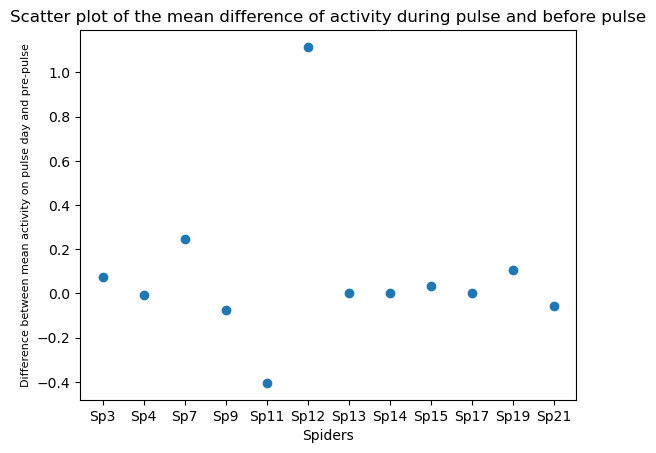

In [62]:
plt.scatter(means_df['Spider'], means_df['Difference']) #connect dots
plt.ylabel("Difference between mean activity on pulse day and pre-pulse", fontsize=8)
plt.xlabel("Spiders")
plt.title("Scatter plot of the mean difference of activity during pulse and before pulse")

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

def filter_and_merge(dataframes, threshold=0):
    merged_filtered_dfs = []
    for name, df in dataframes.items():
        additional_columns = df.columns[:3]
        filtered_dfs = []

        for day in range(1, 9):  
            day_df = df[df['Day'] == day] 
            count_mov = day_df.filter(like="Sp")  
            x = count_mov.sum(axis=0)  
            z = x > threshold  
            columns_to_keep = z[z].index 

            all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
            filtered_df = day_df[all_columns_to_keep]
            filtered_dfs.append(filtered_df)

        merged_df = pd.concat(filtered_dfs)
        merged_df1 = merged_df.dropna(axis=1)
        merged_filtered_dfs.append(merged_df1)
    
    final_merged_df = pd.concat(merged_filtered_dfs)
    return final_merged_df

files = [
    'Steatoda A masking 02 pm.txt', 'Steatoda A masking 10 am.txt',
    'Steatoda A masking 4 am.txt', 'Steatoda A masking midnight.txt'
]

dataframes = process_files(files)

final_merged_df = filter_and_merge(dataframes, threshold=0)

final_merged_df1 = final_merged_df.dropna(axis='columns')

display(final_merged_df1)

,Day,Time,Light,Sp4,Sp9,Sp10,Sp12,Sp14,Sp15,Sp19,Sp21
Index,,,,,,,,,,,
1,1,2024-03-20 11:04:00,1,2.0,5.0,0.0,0.0,0.0,0.0,3.0,1.0
2,1,2024-03-20 11:05:00,1,1.0,8.0,2.0,0.0,3.0,1.0,4.0,1.0
3,1,2024-03-20 11:06:00,1,1.0,8.0,1.0,0.0,5.0,0.0,3.0,1.0
4,1,2024-03-20 11:07:00,1,1.0,12.0,2.0,0.0,0.0,1.0,3.0,3.0
5,1,2024-03-20 11:08:00,1,1.0,10.0,0.0,0.0,4.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
10036,8,2024-04-24 14:58:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10037,8,2024-04-24 14:59:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10038,8,2024-04-24 15:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
